# CNN for CIFAR-10 with Data Augmentation

In [0]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms

In [0]:
import numpy as np

In [0]:
%matplotlib inline
from matplotlib import pyplot as plt

In [4]:
np.random.seed(42)
torch.manual_seed(42)

### Description



Classification of the CIFAR-10 dataset using using a convolutional neural network (CNN) with and without data augmentation.

### GPU

CNNs run very efficiently on a GPU. If a GPU is available we definitely want to take advantage of it. We can automatically set a `device` variable which will define a GPU if it's available and otherwise fallback to a CPU:

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Data Set

### CIFAR-10

The CIFAR-10 dataset is a benchmark dataset for computer vision containing 60000 images divided in 10 classe. The dataset is composed of different photographs of the following classes: airplane, automobile, bird, cat deer, dog, frog, horse, ship, truck. The images are $32 \times 32$ pixels in size and are composed of three channels (RGB).

### Loading the Dataset

CNNs are prone to overfitting since they are very efficient in feature detection and can quickly reach a high performance on the training dataset. A common technique to avoid overfitting is *data augmentation*. Data agmentation consists in adding random modifications to the training data set in order to make it more diverse. For image classification tasks, data augmentation usually consists in random rorations, translations, flips and croppings of the training images. Performing data augmentation in PyTorch is easy: we can define random rotations and translations within the thrnsofrmation used to load the data.

In [0]:
augmentation = transforms.Compose(
    [
        # Data augmentation on images
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)), # Random rotation
        
        # Transform to tensor and normalise
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

_Note_: Transformations for data augmentation are performed by the [Pillow](https://pillow.readthedocs.io/en/stable/) (`PIL`) imaging library and therefore they have to be performed before transforming the images to tensors with `transforms.ToTensor()`.



Using the transformation defined above we can load the dataset:

In [7]:
# Download and load the training dataset
augtrainset = datasets.CIFAR10("data", download=True, train=True, transform=augmentation)

# Download and load the training dataset
augtestset = datasets.CIFAR10("data", download=True, train=False, transform=augmentation)

Files already downloaded and verified
Files already downloaded and verified


_Note_: The transformation is linked to the dataset and therefore is applied on-the-fly during training. This means that every training batch will be slightly different at every epoch.

In order to compare the performance of our model with and without data augmentation we we need to have the same dataset without data augmentation:

In [8]:
# Define usual transformation to tensor with normalisation
transform = transforms.Compose(
    [   
        # Transform to tensor and normalise
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

# Download and load the training dataset
trainset = datasets.CIFAR10("data", download=True, train=True, transform=transform)

# Download and load the training dataset
testset = datasets.CIFAR10("data", download=True, train=False, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


The sizes of the data sets are the following:

In [9]:
print(len(augtrainset), len(augtestset))
print(len(trainset), len(testset))

50000 10000
50000 10000


We see that the size of the data sets with and without data augmentation are the same. This is expected, since the data augmentation transformations are applied on-the-fly.


Finally we can define our `DataLoader` and also get some iterators for the datasets:

In [0]:
# Create DataLoader with batches
augtrainloader = torch.utils.data.DataLoader(augtrainset, batch_size=64, drop_last=True)
augtestloader = torch.utils.data.DataLoader(augtestset, batch_size=64,drop_last=True,)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, drop_last=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, drop_last=True)

# Create iterators
augtrainiter = iter(augtrainloader)
augtestiter = iter(augtestloader)
trainiter = iter(trainloader)
testiter = iter(testloader)

#### Visualizing Images and Labels

Let's define a dictionary mapping labels (numbers from 0 to 9 denoting one of the 10 CIFAR-10 classes) to the acutal classes names:

In [11]:
label_to_name = { 
    i : name 
    for i, name in enumerate(["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]) 
}

print(label_to_name)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


We can visualise one batch of images from the training set, obtained with data augmentation:

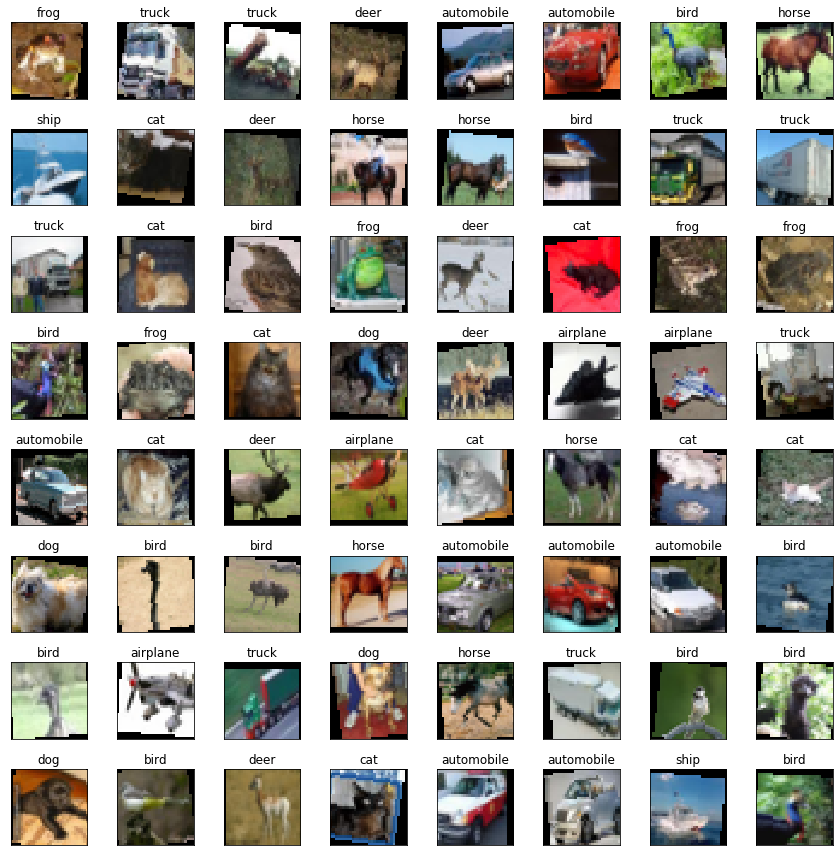

In [12]:
images, labels = next(augtrainiter)

fig = plt.figure(figsize=(12,12))
for idx in range(64):
    ax = fig.add_subplot(8, 8, idx + 1, xticks=[], yticks=[])
    
    # Un-normalize image
    img = images[idx].numpy() * 0.5 + 0.5 

    plt.imshow(np.transpose(img, (1, 2, 0)))
    
    name = label_to_name[labels[idx].item()]
    
    ax.set_title(name, fontdict={"fontsize": 12})

plt.tight_layout()
plt.show()

We can see that data augmentation is taking place when a batch is loaded. Some images are rotated and the empty borders are filled with black pixels.

## Simple CNN

We can now define a CNN with three convolutional and max pooling layers and two fully connected layers:

In [0]:
class CNN(nn.Module):
    def __init__(self):

        super().__init__()

        # 3 channels to 16 channels
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)

        # 16 channels to 32
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)

        # 32 channels to 34
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

        # Pooling without stride goes from n to n/2 pixels
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):

         # Input shape
        assert x.shape == (64, 3, 32, 32)

        # Apply first convolution and activation
        x = F.relu(self.conv1(x))

        # First convolution goes from 3 to 16 channels
        # With padding=1 and kernel_size=3 image size is preserved
        assert x.shape == (64, 16, 32, 32)

        # Apply pooling
        x = self.pool(x)

        assert x.shape == (64, 16, 16, 16)

        # Apply second convolution and activation
        x = F.relu(self.conv2(x))

        # First convolution goes from 16 to 32 channels
        # With padding=1 and kernel_size=3 image size is preserved
        assert x.shape == (64, 32, 16, 16)

        x = self.pool(x)

        assert x.shape == (64, 32, 8, 8)

        # Apply third convolution and activation
        x = F.relu(self.conv3(x))

        # First convolution goes from 32 to 64 channels
        # With padding=1 and kernel_size=3 image size is preserved
        assert x.shape == (64, 64, 8, 8)

        x = self.pool(x)

        assert x.shape == (64, 64, 4, 4)

        # Flatten features for fully connected layers
        x = x.view(-1, 64 * 4 * 4)

        assert x.shape == (64, 64 * 4 * 4)

        x = F.relu(self.fc1(x))

        assert x.shape == (64, 512)

        x = F.log_softmax(self.fc2(x), dim=1)

        assert x.shape == (64, 10)

        return x

Once the model is defined we can instanciate it and move it to the `device`:

In [14]:
modeltest = CNN()
modeltest.to(device)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

### Test Forward Pass

In order to check that our model definition works correctly, we can try to propagate on batch of images through the network. It is important to notice that the data from the `DataLoader` has to be moved to the `device` as well (since the model is now working on the `device`).  We can also plot the class probabilities of this untrained model:

In [15]:
images, labels = next(trainiter)

# Move images and labels to the GPU
images, labels = images.to(device), labels.to(device)

with torch.no_grad(): # Do not track gradients
    # Perform forward pass
    out = modeltest(images)
            
    # Compute class probabilities
    # The model returns log-probabilities
    p = torch.exp(out)

print(torch.mean(p, dim=0))

tensor([0.0974, 0.0963, 0.1034, 0.1057, 0.0954, 0.1033, 0.1010, 0.1005, 0.0967,
        0.1002], device='cuda:0')


As expected for a model with random weights, the class probabilities for each class are close to $1/10$.

### Training

We can now define our training loop including validation where we also save the parameters of the model leading the the lowest loss on the validation set, which will be useful later. We make the use of  `model.train()` and `model.eval()` to specify when the model is training and when the model is being evaluated (validated).

_Note_: Some layers, such as `nn.Dropouts` have different behaviours during training and evaluation. `model.train()` and `model.eval()` are used to make sure that the layers behave correctly.

In [0]:
def train(model, optimizer, loss_function, trainloader, testloader, paramsfile="model.pth", epochs=30, device=device):
    """
    Train a model by optimizing a loss_function using the given optimizer.
    Model and data are moved to the set device.
    """

    import time
    import os

    # Create directory for parameters file
    savedir = os.path.dirname(paramsfile)
    try:
      os.mkdir(savedir)
    except FileExistsError:
      pass

    # Move model to device
    model.to(device)

    train_losses, valid_losses, accuracies = [], [], []

    min_valid_loss = np.Inf

    # Loop over epochs
    for epoch in range(epochs):

        # Start epoch timer
        time_init = time.time()
        
        # Initialize total epoch loss
        epoch_loss = 0
        
        # Training
        model.train()
        for images, labels in trainloader:

            # Move data to GPU
            images, labels = images.to(device), labels.to(device)
        
            # Initialize the gradients to zero
            optimizer.zero_grad()
            
            # Perform forward pass
            output = model(images)
            
            # Compute the loss
            loss = loss_function(output, labels)
            
            # Perform backpropagation
            loss.backward()
            
            # Update the weights
            optimizer.step()
            
            # Accumulate total epoch loss
            epoch_loss += loss.item()
        else:
            valid_loss = 0
            accuracy = 0
            
            # Validation
            # No need totrack gradients during validation
            with torch.no_grad(): 

                model.eval()
                for images, labels in testloader:

                    # Move data to GPU
                    images, labels = images.to(device), labels.to(device)
                    
                    # Perform forward pass
                    output = model(images)
                    
                    # Compute class probabilities
                    p = torch.exp(output)
                    
                    # Compute the loss
                    valid_loss += loss_function(output, labels).item()
                    
                    # Get class of top prediction
                    _, top_c = p.topk(1, dim=1)

                    # Get truth table for the predicted classes
                    equals = (top_c == labels.view_as(top_c)).type(torch.FloatTensor)

                    # Compute accuracy
                    accuracy += torch.mean(equals)
                    
            # Store losses
            train_losses.append(epoch_loss/len(trainloader))
            valid_losses.append(valid_loss/len(testloader))
            accuracies.append(accuracy.item()/len(testloader)*100)

            # Stop epoch timer
            time_end = time.time()

            # Save model
            if valid_losses[-1] < min_valid_loss:
              torch.save(model.state_dict(), paramsfile)
              min_valid_loss = valid_losses[-1]

            if (epoch + 1) % 5 == 0:
              print(f"--- Epoch {epoch+1:2} ---")
              print(f"Train Loss: {train_losses[-1]:.5f}")
              print(f"Valid Loss: {valid_losses[-1]:.5f}")
              print(f"Valid Accuracy: {accuracies[-1]:.2f}%")
              print(f"Time: {time_end - time_init:.3f} s")
    
    return train_losses, valid_losses, accuracies

We can now train the model both with and without data augmentation:

In [0]:
# Loss function (for both models)
nll_loss = nn.NLLLoss()

In [18]:
# Create a model to train with data augmentation
augmodel = CNN()

# Create an optimizer for training with data augmentation
augoptimizer = optim.SGD(augmodel.parameters(), lr=0.05)

augtrainloss, augvalidloss, augaccuracy = train(augmodel, augoptimizer, nll_loss, augtrainloader, augtestloader, "models/augmodel.pth")

--- Epoch  5 ---
Train Loss: 1.15226
Valid Loss: 1.15221
Valid Accuracy: 58.73%
Time: 18.255 s
--- Epoch 10 ---
Train Loss: 0.86175
Valid Loss: 0.93471
Valid Accuracy: 67.45%
Time: 18.280 s
--- Epoch 15 ---
Train Loss: 0.72146
Valid Loss: 0.77752
Valid Accuracy: 73.26%
Time: 18.385 s
--- Epoch 20 ---
Train Loss: 0.63374
Valid Loss: 0.71776
Valid Accuracy: 75.68%
Time: 18.325 s
--- Epoch 25 ---
Train Loss: 0.56957
Valid Loss: 0.73985
Valid Accuracy: 74.62%
Time: 18.425 s
--- Epoch 30 ---
Train Loss: 0.51926
Valid Loss: 0.73464
Valid Accuracy: 75.97%
Time: 18.458 s


In [19]:
# Create a model to train with data augmentation
model = CNN()

# Create an optimizer for training with data augmentation
optimizer = optim.SGD(model.parameters(), lr=0.05)

trainloss, validloss, accuracy = train(model, optimizer, nll_loss, trainloader, testloader, "models/model.pth")

--- Epoch  5 ---
Train Loss: 0.93157
Valid Loss: 0.95199
Valid Accuracy: 66.80%
Time: 12.000 s
--- Epoch 10 ---
Train Loss: 0.45569
Valid Loss: 1.01698
Valid Accuracy: 69.76%
Time: 12.050 s
--- Epoch 15 ---
Train Loss: 0.17945
Valid Loss: 1.51173
Valid Accuracy: 69.58%
Time: 12.149 s
--- Epoch 20 ---
Train Loss: 0.08727
Valid Loss: 1.70000
Valid Accuracy: 71.86%
Time: 12.109 s
--- Epoch 25 ---
Train Loss: 0.04940
Valid Loss: 2.02338
Valid Accuracy: 71.44%
Time: 12.168 s
--- Epoch 30 ---
Train Loss: 0.02588
Valid Loss: 2.08236
Valid Accuracy: 72.57%
Time: 12.003 s


After training the model with and without data augmentation, we can evaluate the impact of such regularisation technique by plotting the training and validation losses:

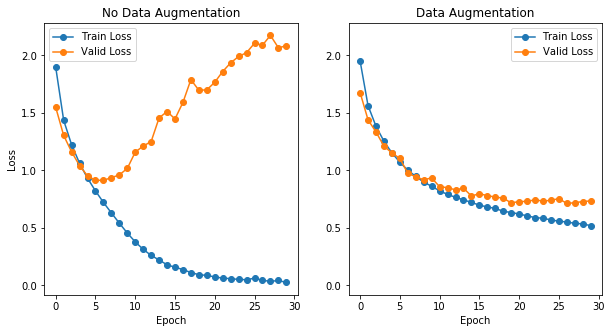

In [20]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(trainloss, "o-", label="Train Loss")
ax1.plot(validloss, "o-", label="Valid Loss")
ax1.set_title("No Data Augmentation")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2 = fig.add_subplot(1, 2, 2, sharey=ax1)
ax2.plot(augtrainloss, "o-", label="Train Loss")
ax2.plot(augvalidloss, "o-", label="Valid Loss")
ax2.set_title("Data Augmentation")
ax2.set_xlabel("Epoch")
ax2.legend()
plt.show()

We see that for the data set without data augmentation, the validation loss start increasing after a few epochs. This is a clear symptom of overfitting. In contrast, training with data augmentation allows the validation loss to decrease further, along with the training loss.

We can also look at what happens to the total accuracy on the validation set:

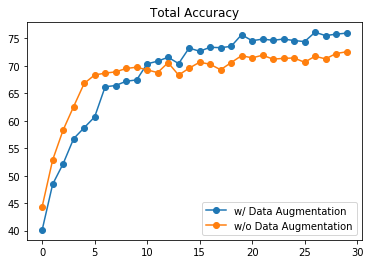

In [21]:
plt.figure()
plt.plot(augaccuracy, "o-", label="w/ Data Augmentation")
plt.plot(accuracy, "o-", label="w/o Data Augmentation")
plt.legend()
plt.title("Total Accuracy")
plt.show()

We see that the model trained with data augmentation is able to reach an higher overall accuracy.

Finally, we canlook at the acccuracy of the predictions:


In [0]:
from collections import defaultdict

def printaccuracy(model, testloader):
    """
    Compute accuracy for different classes.
    """

    # Stop tracking gradients
    with torch.no_grad(): 
      
      # Put model in evaluation mode
      model.eval()

      # Keep track of correctly assigned classes and total number of classes
      c_correct = defaultdict(int)
      c_total = defaultdict(int)

      for images, labels in testloader:

          # Move data to GPU
          images, labels = images.to(device), labels.to(device)
                    
          # Perform forward pass
          output = model(images)
                    
          # Compute class probabilities
          p = torch.exp(output)
                    
          # Get probability and class of top prediction
          top_p, top_c = p.topk(1, dim=1)

          # Get truth table for the predicted classes
          equals = (top_c == labels.view_as(top_c))

          # Count correctly labelled examples
          for i in range(len(labels)):
              label = labels[i].item()
              c_correct[label] += equals[i].item()
              c_total[label] += 1
    
    for i in range(10):
        correct, total = c_correct[i], c_total[i]
        print(f"Test accuracy of {label_to_name[i]:10}: {correct/total * 100:.2f}% ({correct}/{total})")
    print(f"Test accuracy: {sum(c_correct.values())/sum(c_total.values()) * 100:.2f}%")

In [30]:
printaccuracy(augmodel, augtestloader)

Test accuracy of airplane  : 75.15% (750/998)
Test accuracy of automobile: 90.89% (908/999)
Test accuracy of bird      : 64.86% (648/999)
Test accuracy of cat       : 58.07% (579/997)
Test accuracy of deer      : 77.50% (775/1000)
Test accuracy of dog       : 73.62% (734/997)
Test accuracy of frog      : 83.10% (831/1000)
Test accuracy of horse     : 90.27% (900/997)
Test accuracy of ship      : 89.57% (893/997)
Test accuracy of truck     : 84.70% (847/1000)
Test accuracy: 78.78%


In [24]:
printaccuracy(model, testloader)

Test accuracy of airplane  : 75.65% (755/998)
Test accuracy of automobile: 78.58% (785/999)
Test accuracy of bird      : 61.06% (610/999)
Test accuracy of cat       : 54.56% (544/997)
Test accuracy of deer      : 71.30% (713/1000)
Test accuracy of dog       : 63.09% (629/997)
Test accuracy of frog      : 80.90% (809/1000)
Test accuracy of horse     : 75.83% (756/997)
Test accuracy of ship      : 82.95% (827/997)
Test accuracy of truck     : 81.70% (817/1000)
Test accuracy: 72.57%


### Early Stopping

The training loss for the model trained without data augmentation starts increasing after a few epochs. Therefore comparing this model with the one trained using data augmentation at their last epoch can be misleading. *Early stopping* is a common and simple regularization technique that is often applied: training is stopped when the validation loss starts increasing, i.e. when the model starts to overfit. This technique is very effective and simple to implement. Similarly, one can store the model with the lowest validation loss during training for later use in production.

Let's load the best models (according to their loss on the validation set): 

In [25]:
augmodelbest = CNN()
augmodelbest.load_state_dict(torch.load("models/augmodel.pth"))

augmodelbest.to(device)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [26]:
modelbest = CNN()
modelbest.load_state_dict(torch.load("models/model.pth"))

modelbest.to(device)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

We can now compare the accuracies of the best models:

In [27]:
printaccuracy(augmodelbest, augtestloader)

Test accuracy of airplane  : 80.36% (802/998)
Test accuracy of automobile: 86.99% (869/999)
Test accuracy of bird      : 61.56% (615/999)
Test accuracy of cat       : 64.19% (640/997)
Test accuracy of deer      : 68.40% (684/1000)
Test accuracy of dog       : 63.69% (635/997)
Test accuracy of frog      : 81.20% (812/1000)
Test accuracy of horse     : 82.05% (818/997)
Test accuracy of ship      : 88.97% (887/997)
Test accuracy of truck     : 77.70% (777/1000)
Test accuracy: 75.51%


In [29]:
printaccuracy(modelbest, testloader)

Test accuracy of airplane  : 73.95% (738/998)
Test accuracy of automobile: 76.98% (769/999)
Test accuracy of bird      : 53.65% (536/999)
Test accuracy of cat       : 60.48% (603/997)
Test accuracy of deer      : 64.80% (648/1000)
Test accuracy of dog       : 45.04% (449/997)
Test accuracy of frog      : 58.60% (586/1000)
Test accuracy of horse     : 86.06% (858/997)
Test accuracy of ship      : 89.67% (894/997)
Test accuracy of truck     : 77.60% (776/1000)
Test accuracy: 68.68%
